In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import splitfolders

In [42]:
data_dir = 'D://cavity_images//mask_bbox//'

In [43]:
splitfolders.ratio(data_dir + 'raw', 
                   output=data_dir + "output", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) # default values

In [44]:
batch_size = 32
img_height = 80
img_width = 80

In [45]:
datagen = ImageDataGenerator()

In [46]:
train_generator = datagen.flow_from_directory(
    directory=data_dir+ 'output/train',
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)
valid_generator = datagen.flow_from_directory(
    directory=data_dir+ 'output/val',
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)
test_generator = datagen.flow_from_directory(
    directory=data_dir+ 'output/test',
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=1,
    class_mode="binary",
    shuffle=True,
    seed=42
)

Found 1031 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Found 298 images belonging to 3 classes.


In [47]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [48]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(80, 80,1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 64)       

In [50]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [51]:
checkpoint_dir = './logs/masks'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True)

In [52]:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=30)

Epoch 1/30
32/32 [==============================] - 5s 155ms/step - loss: 20.0240 - accuracy: 0.5265 - val_loss: 0.6699 - val_accuracy: 0.5590
Epoch 2/30
32/32 [==============================] - 0s 14ms/step - loss: 0.8985 - accuracy: 0.5325 - val_loss: 0.6779 - val_accuracy: 0.5347
Epoch 3/30
32/32 [==============================] - 0s 14ms/step - loss: 0.7016 - accuracy: 0.5606 - val_loss: 0.6431 - val_accuracy: 0.6111
Epoch 4/30
32/32 [==============================] - 0s 14ms/step - loss: 0.9229 - accuracy: 0.5706 - val_loss: 0.7053 - val_accuracy: 0.5729
Epoch 5/30
32/32 [==============================] - 0s 14ms/step - loss: 0.8310 - accuracy: 0.5916 - val_loss: 0.7306 - val_accuracy: 0.5660
Epoch 6/30
32/32 [==============================] - 0s 14ms/step - loss: 0.6708 - accuracy: 0.6126 - val_loss: 0.6630 - val_accuracy: 0.5868
Epoch 7/30
32/32 [==============================] - 0s 14ms/step - loss: 0.6556 - accuracy: 0.6226 - val_loss: 0.6532 - val_accuracy: 0.6181
Epoch 8/30


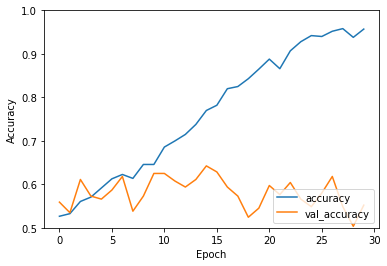

In [55]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('../figures/morphology_train.png')
#plt.show()